# Capstone Project
## 3D Semantic Segmentation - Colon Cancer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing Dependencies

In [ ]:
import os
import tarfile
import fnmatch

import numpy as np
import pandas as pd
import nibabel as nib
from collections import Counter

from sklearn.preprocessing import normalize as sklearn_normalize
from skimage.morphology import binary_opening


from matplotlib import pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

In [ ]:
data = '/content/gdrive/My Drive/Capstone/Task10_Colon'

## Helper Functions

In [ ]:
class Capstone :

  def __init__(self) :

    """Defining all the directories"""


    self.dir = data
    self.train_dir = "/imagesTr/"
    self.test_dir = "/imagesTs/"
    self.labels_dir = "/labelsTr/"

    self.train_dir_1 = self.dir +  self.train_dir
    self.labels_dir_1 = self.dir +  self.labels_dir
    self.test_dir_1 = self.dir +  self.test_dir
    
    self.img_shape = None

  def get_train_set(self) :

    """Fetches Train Images and Masks from the respective directories and stores as Numpy Array

    Returns: 
      train_set: A numpy array consisting of train images
      gt_set : A  numpy array of train labels
    """

    self.files          = [f for f in os.listdir(self.train_dir_1) if fnmatch.fnmatch(f, "[!.]*.nii.gz")]
    self.files_gt       = [f for f in os.listdir(self.labels_dir_1) if fnmatch.fnmatch(f, "[!.]*.nii.gz")]
    self.n_train_sample = len(self.files)
    self.n_gt_sample    = len(self.files_gt)
    self.train_set      = np.empty(50, dtype=object)
    self.gt_set         = np.empty(50, dtype=object)

    for i in range(50) :
      img = nib.load(self.train_dir_1 + self.files[i]).get_data()
      self.train_set[i] = img

    for i in range(50) :
      img = nib.load(self.labels_dir_1 + self.files[i]).get_data()
      self.gt_set[i] = img
    
    return self.train_set, self.gt_set
 
  def get_test_set(self) :
    """Fetches Test Images  from the respective directories and stores as Numpy Array

    Returns: 
      test_set: A numpy array consisting of train images
    """
 
    self.files_test     = [f for f in os.listdir(self.test_dir_1) if fnmatch.fnmatch(f, "[!.]*.nii.gz")]
    self.n_test_sample  = len(self.files_test)
    self.test_set       = np.empty(15, dtype=object)

    for i in range(15) : 
      img = nib.load(self.test_dir_1 + self.files_test[i]).get_data()
      self.test_set[i] = img

    return self.test_set
  
  def display_train_set(self, nb_patient=10, slice_index=30) :

    """Displays Train Set images and its respective image mask

    Args:
      nb_patient: Number of patient scans to display
      slice_index : 3D Index of the image 
    """
    fig = plt.figure(figsize= (7, 50), dpi = 90)

    k = 0
    for i in range(nb_patient) :

        plt.subplot(10, 2, k + 1)
        plt.imshow(self.train_set[i][:,:,slice_index])
        plt.subplots_adjust(wspace = 0)
        plt.title("original")
        plt.axis('off')

        k += 1 
        
        mask = self.gt_set[i][:, :, slice_index] == 1
        tmp = self.gt_set[i][:, :, slice_index]
        tmp[mask] = 2000

        plt.subplot(10, 2, k + 1)
        plt.imshow(tmp)
        plt.title("Label")
        plt.subplots_adjust(wspace = 0)
        plt.axis('off')

        k += 1

  def get_max_occurence_value(self, x) :
    """Finds the most frequent image size from the given list

    Args:
      x: List containing all sizes

    Returns: 
      Value: Most frequently occuring image size
    """    
    inv_map = {v: k for k, v in Counter(x).items()}
    return inv_map[max(inv_map.keys())]

  def get_img_shape(self) :
    """Fetches Image size


    Returns: 
      img_shape: Image Dimensions
    """
    size_list_x = []
    size_list_y = []
    
    for patient_data in self.train_set :
      size_list_x.append(patient_data.shape[0])
      size_list_y.append(patient_data.shape[1])
    
    self.img_shape = (self.get_max_occurence_value(size_list_x),
                      self.get_max_occurence_value(size_list_y))
    return self.img_shape


  def normalize(self, x) :
    """Performs Normalization of the numpy array

    Args:
      x = Array to be normalized

    Returns: 
      x : Normalized array
      
    """

    for i in range(x.shape[0]):
      x[i] = sklearn_normalize(x[i], norm='max', copy=True, return_norm=False)
    return x

  def get_x_train(self) :
    """Performs axial cuts on the 3D image in order to get 2D slices

    Returns: 
      x_train: A numpy array consisting of train images(2D)
    """    

    self.x_train_len = 0
    for patient_data in self.train_set :
      self.x_train_len += patient_data.shape[2]
 
    if self.img_shape is None :
      self.get_img_shape()
    
    self.x_train = [] 

    i = 0
    for patient_data in self.train_set :
      for j in range(patient_data.shape[2]) :
        if patient_data.T[j].shape == self.img_shape :
          self.x_train.append(patient_data.T[j])
        else :
          self.x_train.append(np.resize(patient_data.T[j], self.img_shape))

    self.x_train = np.array(self.x_train)
    self.x_train = self.normalize(self.x_train)

    return self.x_train

  def get_y_train(self) :
    """Performs axial cuts on the 3D image in order to get 2D slices

    Returns: 
      y_train: A numpy array consisting of train labels(2D)
    """      

    self.y_train_len = 0
    for patient_data in self.gt_set :
      self.y_train_len += patient_data.shape[2]

    if self.img_shape is None :
      self.get_img_shape()
    
    self.y_train = []

    i = 0
    for patient_data in self.gt_set :
      for j in range(patient_data.shape[2]) :
        if patient_data.T[j].shape == self.img_shape :
          self.y_train.append(patient_data.T[j])
        else :
          self.y_train.append(np.resize(patient_data.T[j], self.img_shape))

    self.y_train = np.array(self.y_train)
    self.y_train = self.normalize(self.y_train)

    return self.y_train

 
  def get_x_test(self) :
    """Performs axial cuts on the 3D image in order to get 2D slices

    Returns: 
      x_train: A numpy array consisting of test images(2D)
    """        
    self.x_test_len = 0
    for patient_data in self.test_set :
      self.x_test_len += patient_data.shape[2]

    if self.img_shape is None :
      self.get_img_shape()
    
    self.x_test = []

    i = 0
    for patient_data in self.test_set :
      for j in range(patient_data.shape[2]) :
        if patient_data.T[j].shape == self.img_shape :
          self.x_test.append(patient_data.T[j])
        else :
          self.x_test.append(np.resize(patient_data.T[j], self.img_shape))

    self.x_test = np.array(self.x_test)
    self.x_test = self.normalize(self.x_test)

    return self.x_test


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.datao

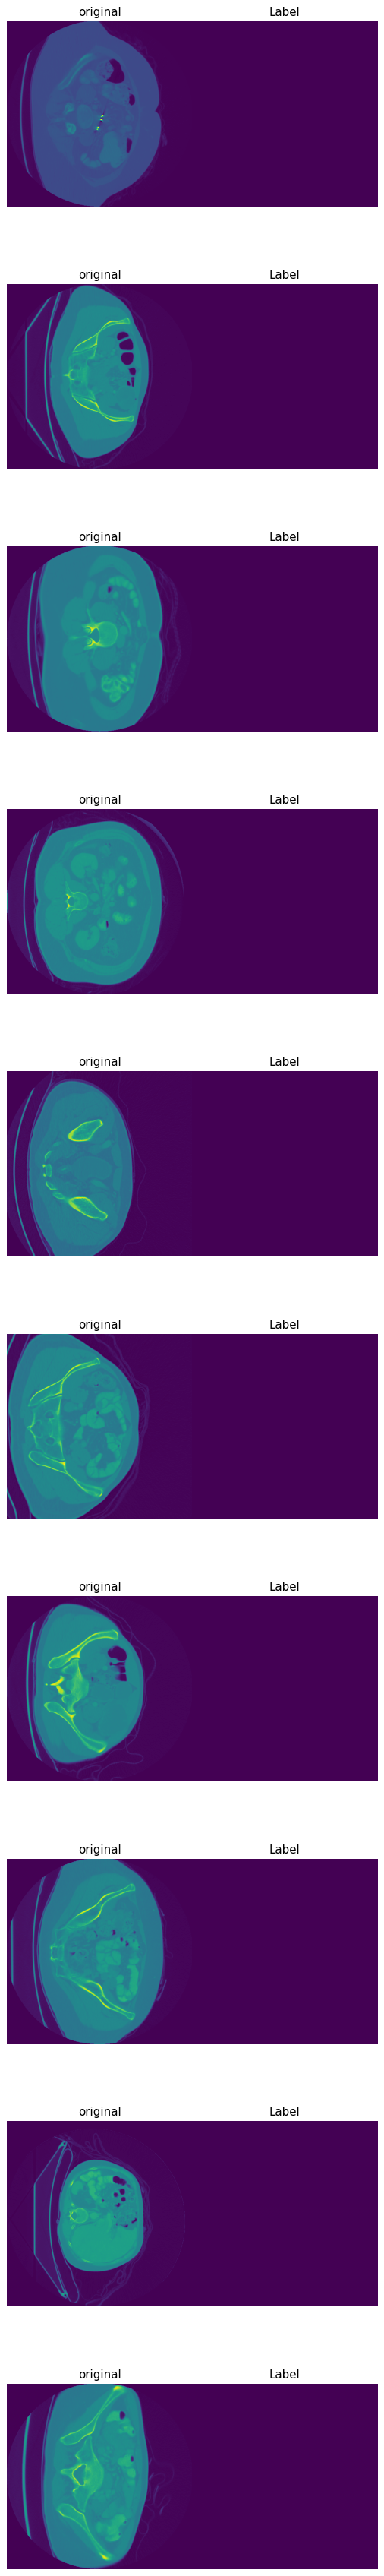

In [ ]:
capstone = Capstone()
capstone.get_train_set()
capstone.get_test_set()
capstone.display_train_set()

In [ ]:
x_train, y_train,x_test = capstone.get_x_train(), capstone.get_y_train(),capstone.get_x_test()
x_train.shape, y_train.shape,x_test.shape

((4830, 512, 512), (4830, 512, 512), (663, 512, 512))

In [ ]:
x_test = capstone.get_x_test()
x_test.shape

(1743, 512, 512)

## Creating U-Net model

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):

    """Defines a Convolution pass for the Network

    Args:
      input_tensor: Input Dimensions which are to be given to the model
      n_filters: Number Of Filters to start with
      kernel_size: Dimensions of the kernel to be used
      batchnorm: Boolean value which indicates if batchnorm is to be performed or not

    Returns: 
      x: Input for the next Convolution Block
    """  
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    
    
    """Defines the Architecture of U-Net
    
    Args:
      input_img: Input Dimensions which are to be given to the model
      n_filters: Number Of Filters to start with
      dropout: Rate of dropout
      batchnorm: Boolean value which indicates if batchnorm is to be performed or not

    Returns: 
      x: U-Net model is returned
    """    

    #Contraction Path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## Defining Dice-Coefficient

In [ ]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):

    """Defines the Dice Coefficient Metric

    Args:
      y_true: Actual label
      y_pred: Predicted Label
      smooth: To avoid division by zero

    Returns: 
      dice: Calculated dice score
    """    
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice


def dice_coef_loss(y_true, y_pred):

    """Defines the Dice Loss Metric

    Args:
      y_true: Actual label
      y_pred: Predicted Label

    Returns: 
      Value: Calculated dice Loss
    """    
    return -tf.math.log( dice_coef(y_true, y_pred))

In [ ]:
input_img = Input((capstone.img_shape[0], capstone.img_shape[1], 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Reshaping according to model's input

In [ ]:
x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2] ,1))

array([[[[ 1.1082251],
         [ 1.1082251],
         [ 1.1082251],
         ...,
         [ 1.1082251],
         [ 1.1082251],
         [ 1.1082251]],

        [[ 1.1010753],
         [ 1.1010753],
         [ 1.1010753],
         ...,
         [ 1.1010753],
         [ 1.1010753],
         [ 1.1010753]],

        [[ 1.0987124],
         [ 1.0987124],
         [ 1.0987124],
         ...,
         [ 1.0987124],
         [ 1.0987124],
         [ 1.0987124]],

        ...,

        [[ 1.0385395],
         [ 1.0385395],
         [ 1.0385395],
         ...,
         [ 1.0385395],
         [ 1.0385395],
         [ 1.0385395]],

        [[ 1.0364373],
         [ 1.0364373],
         [ 1.0364373],
         ...,
         [ 1.0364373],
         [ 1.0364373],
         [ 1.0364373]],

        [[ 1.0343435],
         [ 1.0343435],
         [ 1.0343435],
         ...,
         [ 1.0343435],
         [ 1.0343435],
         [ 1.0343435]]],


       [[[ 1.1010753],
         [ 1.1010753],
         [ 1.1

## Training Model

In [ ]:
epoch = 10
batch_size = 32

model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

history = model.fit(x = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2] ,1)),
                    y = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2] ,1)),
                    batch_size=batch_size, epochs = epoch,
                    validation_split=0.1,
                    callbacks=[model_checkpoint],verbose=1)

Epoch 1/10
136/136 [==============================] - 114s 835ms/step - loss: 6.1155 - dice_coef: 0.0035 - val_loss: 7.0988 - val_dice_coef: 9.5482e-04
Epoch 2/10
136/136 [==============================] - 110s 809ms/step - loss: 5.7305 - dice_coef: 0.0051 - val_loss: 9.8860 - val_dice_coef: 0.0012
Epoch 3/10
136/136 [==============================] - 110s 810ms/step - loss: 5.5743 - dice_coef: 0.0062 - val_loss: 7.2901 - val_dice_coef: 0.0019
Epoch 4/10
136/136 [==============================] - 110s 810ms/step - loss: 5.2766 - dice_coef: 0.0073 - val_loss: 7.6216 - val_dice_coef: 0.0039
Epoch 5/10
136/136 [==============================] - 110s 811ms/step - loss: 2.6199 - dice_coef: 0.2265 - val_loss: 0.3269 - val_dice_coef: 0.7335
Epoch 6/10
136/136 [==============================] - 110s 811ms/step - loss: 0.2317 - dice_coef: 0.7954 - val_loss: 0.1568 - val_dice_coef: 0.8691
Epoch 7/10
136/136 [==============================] - 110s 811ms/step - loss: 0.1620 - dice_coef: 0.8521 - v

## Plotting Dice-Score Curves

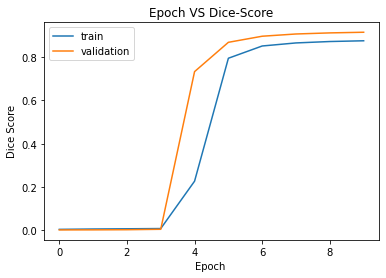

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Epoch VS Dice-Score')
plt.ylabel('Dice Score')
plt.xlabel('Epoch ')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


## Plotting Loss Curves


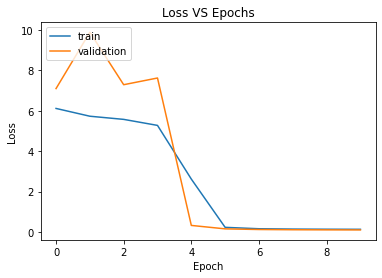

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss VS Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:

model_loaded = load_model('/content/weights.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

In [ ]:
model_loaded.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Checking Model latency

In [ ]:
%%time 
from datetime import datetime

elapsed_time = 0
s = datetime.now().time()
print(s)
pred_zero = model_loaded.predict(x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2] ,1)))

e = datetime.now().time()
print(e)
# only interested on the time part, not the date
start_time = datetime.strptime(str(s), '%H:%M:%S.%f')

end_time = datetime.strptime(str(e), '%H:%M:%S.%f')

diff = end_time - start_time
elapsed_time = int((diff.seconds * 1000) + (diff.microseconds / 1000))


08:03:38.825055
08:04:01.793824
CPU times: user 10.7 s, sys: 8.1 s, total: 18.8 s
Wall time: 23 s


### Optimizing the Model using TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp0l38dm9e/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image = nib.load('/content/gdrive/My Drive/Capstone/Task10_Colon/imagesTr/colon_102.nii.gz')

# Test model on random input data.
s = datetime.now().time()
input_shape = input_details[0]['shape']
input_data = np.array(x_test[0].reshape(1,512,512,1), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

elapsed_time = 0

#print(s)
output_data = interpreter.get_tensor(output_details[0]['index'])
#print(output_data)

e = datetime.now().time()
#print(e)
# only interested on the time part, not the date
start_time = datetime.strptime(str(s), '%H:%M:%S.%f')

end_time = datetime.strptime(str(e), '%H:%M:%S.%f')

diff = end_time - start_time
elapsed_time = int((diff.seconds * 1000) + (diff.microseconds / 1000))

In [ ]:
elapsed_time

311

In [ ]:
#@title Testing
def postprocess(x, treshold = 0.5) : 
    for i in range(x.shape[0]):
         x[x >= treshold] = 1
         x[x < treshold] = 0
         x[i] = binary_opening(x[i , :, :] == 1)
    return x

In [ ]:
y_test = model_loaded.predict(x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2] ,1)))


In [ ]:

y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2]))
y_test.shape

(1743, 512, 512)

In [ ]:
y_test_post_process = postprocess(y_test[:10])
y_test_post_process.shape

(10, 512, 512)

In [ ]:
y_test

In [ ]:

fig = plt.figure(figsize= (100,100), dpi = 210)

n_slice = 40

k = 0
for i in range(100) : 


      tmp = y_test[i, :, :]
      
      plt.subplot(100, 2, k + 1)
      plt.imshow(tmp)
      plt.axis("off")

      k+= 1
